In [1]:
import pandas as pd
import numpy as np

In [3]:
train_df = pd.read_parquet("Data/train_final_v3.parquet")
val_df = pd.read_parquet("Data/validationA_v3.parquet")

In [5]:
print(train_df.shape)
print(val_df.shape)

(112768, 791)
(24164, 791)


In [24]:
train_df.iloc[:,:25].dtypes

category                            object
missing_price                         bool
item_rank                          float64
match                                int64
avg_rating                         float64
min_rating                           int64
percent_positive                   float64
percent_negative                   float64
avg_verified_reviewers             float64
min_date                    datetime64[ns]
max_date                    datetime64[ns]
product_lifespan           timedelta64[ns]
num_bots_per_asin                    int64
unique_reviewer_count                int64
avg_reviews_per_day                float64
reviews_per_product                  int64
avg_review_length_words            float64
embed_0                            float64
embed_1                            float64
embed_2                            float64
embed_3                            float64
embed_4                            float64
embed_5                            float64
embed_6    

In [7]:
X_train = train_df.drop(columns=['match'], axis=1)
X_val = val_df.drop(columns=['match'], axis=1)
y_train = train_df['match']
y_val = val_df['match']

## Column Types

In [30]:
for df in (X_train, X_val):
    df['review_span'] = (df['max_date'] - df['min_date']).dt.days
    df.drop(['min_date', 'max_date'], axis=1, inplace=True)

for df in (X_train, X_val):
    df['missing_price'] = df['missing_price'].astype(int)

for df in (X_train, X_val):
    df['product_lifespan_days'] = df['product_lifespan'].dt.days
    df.drop('product_lifespan', axis=1, inplace=True)

print(f"The shape of X_train: {X_train.shape}, X_val: {X_val.shape}")

The shape of X_train: (112768, 789), X_val: (24164, 789)


## Correlation Analysis

In [43]:
corr_matrix = X_train.drop(columns=['category'], axis=1).corr(method='pearson')  
# Get high-correlation pairs
high_corr = (corr_matrix.abs() > 0.9) & (corr_matrix.abs() < 1.0)
high_corr_pairs = high_corr.stack().loc[lambda x: x].reset_index()
high_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']

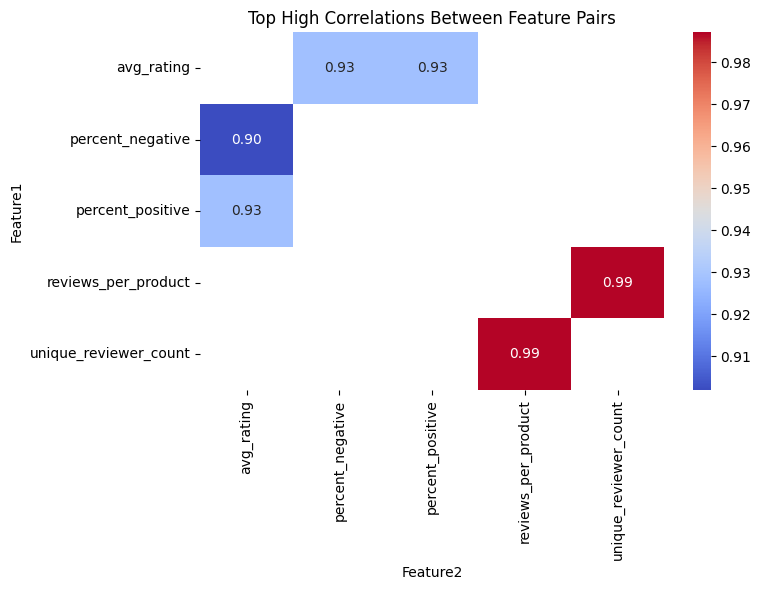

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get top N correlated feature pairs
N = 50 
top_corr_pairs = high_corr_pairs.copy()
top_corr_pairs['AbsCorr'] = top_corr_pairs['Feature1'].map(
    lambda f1: corr_matrix.loc[f1, top_corr_pairs.loc[top_corr_pairs['Feature1'] == f1, 'Feature2']].values[0]
).abs()

top_corr_pairs = top_corr_pairs.sort_values('AbsCorr', ascending=False).head(N)

# Pivot for heatmap format
pivot_df = top_corr_pairs.pivot(index='Feature1', columns='Feature2', values='AbsCorr')

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Top High Correlations Between Feature Pairs")
plt.tight_layout()
plt.show()

We will drop the columns `percent_positive`, `percent_negative`, and `unique_reviewer_count` as they exhibit high correlation with other features, which may introduce multicollinearity into the model.


In [55]:
for df in (X_train, X_val):
    df.drop(['percent_positive', 'percent_negative', 'unique_reviewer_count'], axis=1, inplace=True)

## Pre-processing and PCA on Embedding Vectors

In [65]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
import numpy as np

# STEP 1: Separate embedding and non-embedding features
embedding_cols = [col for col in X_train.columns if col.startswith('emb')]

X_emb_train = X_train[embedding_cols].copy()
X_emb_val   = X_val[embedding_cols].copy()

X_train_nonemb = X_train.drop(columns=embedding_cols)
X_val_nonemb   = X_val.drop(columns=embedding_cols)

# STEP 2: Preprocess non-embedding features (standard scaling + one-hot)
categorical_cols = ['category']  
numeric_cols     = [col for col in X_train_nonemb.columns if col not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(),  numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore',  sparse_output=False), categorical_cols),
    ]
)

X_train_nonemb_proc = preprocessor.fit_transform(X_train_nonemb)
X_val_nonemb_proc   = preprocessor.transform(X_val_nonemb)

# STEP 3: Scale embeddings before PCA
scaler_emb = StandardScaler()
X_emb_train_scaled = scaler_emb.fit_transform(X_emb_train)
X_emb_val_scaled   = scaler_emb.transform(X_emb_val)

# STEP 4: Apply PCA to scaled embeddings
pca = PCA(n_components=0.95, random_state=42)
X_emb_train_reduced = pca.fit_transform(X_emb_train_scaled)
X_emb_val_reduced   = pca.transform(X_emb_val_scaled)


## Multicollinearity: Variance Inflation Factor (VIF) On Non-Embedding Features:

In [89]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Get column names from preprocessor
vif_feature_names = (
    numeric_cols +
    list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
)
X_df_for_vif = pd.DataFrame(X_train_nonemb_proc, columns=vif_feature_names)

# VIF calculation 
vif_data = pd.DataFrame()
vif_data["feature"] = X_df_for_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_df_for_vif.values, i)
                   for i in range(X_df_for_vif.shape[1])]

C:\Users\Betul\anaconda3\envs\pytorch_env\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [94]:
# Print features with VIF > 10
high_vif = vif_data[vif_data["VIF"] > 10].sort_values("VIF", ascending=False)

print("Features with VIF > 10:")
print(high_vif.to_string(index=False))

Features with VIF > 10:
              feature  VIF
          review_span  inf
product_lifespan_days  inf


In [96]:
# Iterative VIF Filtering Loop
while True:
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_df_for_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(X_df_for_vif.values, i)
                       for i in range(X_df_for_vif.shape[1])]
    
    if vif_data["VIF"].max() <= 10:
        break

    drop_feature = vif_data.sort_values("VIF", ascending=False).iloc[0]["feature"]
    print(f"Dropping {drop_feature} with VIF = {vif_data['VIF'].max():.2f}")
    X_df_for_vif = X_df_for_vif.drop(columns=[drop_feature])

C:\Users\Betul\anaconda3\envs\pytorch_env\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropping review_span with VIF = inf


In [101]:
# Reconstruct validation DataFrame using the same feature names
X_val_nonemb_proc_df = pd.DataFrame(X_val_nonemb_proc, columns=vif_feature_names)

# Align columns with what's left in X_df_for_vif
X_val_nonemb_filtered = X_val_nonemb_proc_df[X_df_for_vif.columns]

# Final feature name list
final_feature_names = (
    X_df_for_vif.columns.tolist() +
    [f"pca_emb_{i}" for i in range(X_emb_train_reduced.shape[1])]
)

# Combine filtered non-embedding and PCA-reduced embedding features
X_train_final_df = pd.DataFrame(
    np.hstack([X_df_for_vif.values, X_emb_train_reduced]),
    columns=final_feature_names
)

X_val_final_df = pd.DataFrame(
    np.hstack([X_val_nonemb_filtered.values, X_emb_val_reduced]),
    columns=final_feature_names
)

In [104]:
X_train_final_df1 = X_train_final_df
X_val_final_df1 = X_val_final_df

## Generate Feature Processor Class After Those Preprocessing Steps:

In [114]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor

class FeatureProcessor:
    def __init__(self, numeric_cols, categorical_cols):
        self.numeric_cols = numeric_cols
        self.categorical_cols = categorical_cols

        self.preprocessor = None
        self.scaler_emb = None
        self.pca = None

        self.vif_keep_columns = None
        self.final_feature_names = None
        self.embedding_cols = None
        self.preproc_feature_names = None

    def _preprocess_dates_and_flags(self, df):
        df = df.copy()

        if 'max_date' in df.columns and 'min_date' in df.columns:
            df['review_span'] = (df['max_date'] - df['min_date']).dt.days
            df.drop(['min_date', 'max_date'], axis=1, inplace=True)

        if 'missing_price' in df.columns:
            df['missing_price'] = df['missing_price'].astype(int)

        if 'product_lifespan' in df.columns:
            df['product_lifespan_days'] = df['product_lifespan'].dt.days
            df.drop('product_lifespan', axis=1, inplace=True)

        drop_cols = [c for c in ['percent_positive', 'percent_negative', 'unique_reviewer_count'] if c in df.columns]
        df.drop(columns=drop_cols, errors='ignore', inplace=True)

        return df

    def fit(self, X_raw, skip_vif=False):
        X_raw = self._preprocess_dates_and_flags(X_raw)

        # Separate embeddings
        self.embedding_cols = [col for col in X_raw.columns if col.startswith('emb')]
        X_emb = X_raw[self.embedding_cols]
        X_nonemb = X_raw.drop(columns=self.embedding_cols)

        # Fit ColumnTransformer
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), self.numeric_cols),
                ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), self.categorical_cols),
            ]
        )
        X_nonemb_proc = self.preprocessor.fit_transform(X_nonemb)
        self.preproc_feature_names = (
            self.numeric_cols +
            list(self.preprocessor.named_transformers_['cat'].get_feature_names_out(self.categorical_cols))
        )

        # VIF filtering
        if not skip_vif:
            X_vif = pd.DataFrame(X_nonemb_proc, columns=self.preproc_feature_names)
            while True:
                vif_data = pd.DataFrame()
                vif_data["feature"] = X_vif.columns
                vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                                   for i in range(X_vif.shape[1])]
                if vif_data["VIF"].max() <= 10:
                    break
                drop_feature = vif_data.sort_values("VIF", ascending=False).iloc[0]["feature"]
                print(f"Dropping {drop_feature} with VIF = {vif_data['VIF'].max():.2f}")
                X_vif = X_vif.drop(columns=[drop_feature])
            self.vif_keep_columns = X_vif.columns.tolist()
        else:
            X_nonemb_df = pd.DataFrame(X_nonemb_proc, columns=self.preproc_feature_names)
            X_vif = X_nonemb_df[self.vif_keep_columns]

        # Scale and reduce embeddings
        self.scaler_emb = StandardScaler()
        X_emb_scaled = self.scaler_emb.fit_transform(X_emb)

        self.pca = PCA(n_components=0.95, random_state=42)
        X_emb_reduced = self.pca.fit_transform(X_emb_scaled)

        # Final DataFrame
        self.final_feature_names = self.vif_keep_columns + [f'pca_emb_{i}' for i in range(X_emb_reduced.shape[1])]
        return pd.DataFrame(np.hstack([X_vif.values, X_emb_reduced]), columns=self.final_feature_names)

    def transform(self, X_raw):
        X_raw = self._preprocess_dates_and_flags(X_raw)

        # Separate embeddings
        X_emb = X_raw[self.embedding_cols]
        X_nonemb = X_raw.drop(columns=self.embedding_cols)

        # Transform non-embedding
        X_nonemb_proc = self.preprocessor.transform(X_nonemb)
        X_nonemb_df = pd.DataFrame(X_nonemb_proc, columns=self.preproc_feature_names)
        X_vif = X_nonemb_df[self.vif_keep_columns]

        # Transform embeddings
        X_emb_scaled = self.scaler_emb.transform(X_emb)
        X_emb_reduced = self.pca.transform(X_emb_scaled)

        return pd.DataFrame(np.hstack([X_vif.values, X_emb_reduced]), columns=self.final_feature_names)

In [116]:
# Final vif columns
final_vif_columns = X_df_for_vif.columns.tolist()

print(f"Final vif columns: {final_vif_columns}")

processor = FeatureProcessor(numeric_cols, categorical_cols)
processor.vif_keep_columns = final_vif_columns

X_train_final_df = processor.fit(train_df.drop(columns=['match'], axis=1), skip_vif=True)
X_val_final_df   = processor.transform(val_df.drop(columns=['match'], axis=1))

Final vif columns: ['missing_price', 'item_rank', 'avg_rating', 'min_rating', 'avg_verified_reviewers', 'num_bots_per_asin', 'avg_reviews_per_day', 'reviews_per_product', 'avg_review_length_words', 'mean_sentiment_score', 'mean_complaint_similarity', 'mean_shipping_similarity', 'max_complaint_similarity', 'shipping_similarity_at_max_complaint', 'sentiment_score_at_max_complaint', 'product_lifespan_days', 'category_Action Figures & Statues', 'category_Arts & Crafts', 'category_Baby & Toddler Toys', 'category_Building Toys', 'category_Dolls & Accessories', 'category_Dress Up & Pretend Play', 'category_Games', 'category_Grown-Up Toys', 'category_Hobbies', "category_Kids' Electronics", "category_Kids' Furniture, Dcor & Storage", 'category_Learning & Education', 'category_Novelty & Gag Toys', 'category_Party Supplies', 'category_Puppets', 'category_Puzzles', 'category_Sports & Outdoor Play', 'category_Stuffed Animals & Plush Toys', 'category_Toy Remote Control & Play Vehicles', 'category_Tr

In [124]:
print((X_train_final_df == X_train_final_df1).all().all())
print((X_val_final_df == X_val_final_df1).all().all())

True
True


In [126]:
# Save preprocessed columns:
X_train_final_df.to_pickle("X_train_final_df.pkl")
X_val_final_df.to_pickle("X_val_final_df.pkl")

In [9]:
# Load preprocessed columns
X_train_final_df = pd.read_pickle("X_train_final_df.pkl")
X_val_final_df   = pd.read_pickle("X_val_final_df.pkl")

# Model Training

In [13]:
from sklearn.metrics import (
    precision_score, recall_score, f1_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay, accuracy_score
)
import matplotlib.pyplot as plt

class ModelEvaluator:
    def __init__(self, model, average='binary', display_labels=None):
        self.model = model
        self.average = average
        self.display_labels = display_labels

    def evaluate_classification(self, y_true, y_pred):
        prec = precision_score(y_true, y_pred, average=self.average)
        rec  = recall_score   (y_true, y_pred, average=self.average)
        f1   = f1_score       (y_true, y_pred, average=self.average)

        print(f"Precision: {prec:.3f}")
        print(f"Recall:    {rec:.3f}")
        print(f"F1-score:  {f1:.3f}\n")

        print("Classification Report:\n", classification_report(y_true, y_pred))

        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=self.display_labels)
        fig, ax = plt.subplots(figsize=(5, 5))
        disp.plot(ax=ax, cmap='Blues')
        ax.set_title("Confusion Matrix")
        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self, feature_names, top_n=30):
        if hasattr(self.model, "feature_importances_"):
            # Tree-based models
            importances = self.model.feature_importances_
            indices = importances.argsort()[::-1][:top_n]
    
            plt.figure(figsize=(10, 6))
            plt.barh(range(top_n), importances[indices][::-1])
            plt.yticks(range(top_n), [feature_names[i] for i in indices][::-1])
            plt.title("Top Feature Importances (Tree-based)")
            plt.tight_layout()
            plt.show()
    
        elif hasattr(self.model, "coef_"):
            # Linear models like Logistic Regression
            coefs = self.model.coef_.ravel()
            abs_coefs = np.abs(coefs)
            indices = abs_coefs.argsort()[::-1][:top_n]
    
            plt.figure(figsize=(10, 6))
            plt.barh(range(top_n), coefs[indices][::-1])
            plt.yticks(range(top_n), [feature_names[i] for i in indices][::-1])
            plt.title("Top Logistic Regression Coefficients")
            plt.axvline(0, color='black', linestyle='--', linewidth=0.7)
            plt.tight_layout()
            plt.show()
    
        else:
            print("This model does not support feature importance or coefficients.")



    def fit_and_evaluate(self, X_train, y_train, X_val, y_val):
        print("Training model...")
        self.model.fit(X_train, y_train)

        print("\n📊 Training Performance:")
        y_train_pred = self.model.predict(X_train)
        self.evaluate_classification(y_train, y_train_pred)

        print("\n📈 Validation Performance:")
        y_val_pred = self.model.predict(X_val)
        self.evaluate_classification(y_val, y_val_pred)

        return self.model


## Logistic Regression

Training model...

📊 Training Performance:
Precision: 0.521
Recall:    0.891
F1-score:  0.504

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.86      0.93    112000
           1       0.04      0.92      0.08       768

    accuracy                           0.86    112768
   macro avg       0.52      0.89      0.50    112768
weighted avg       0.99      0.86      0.92    112768



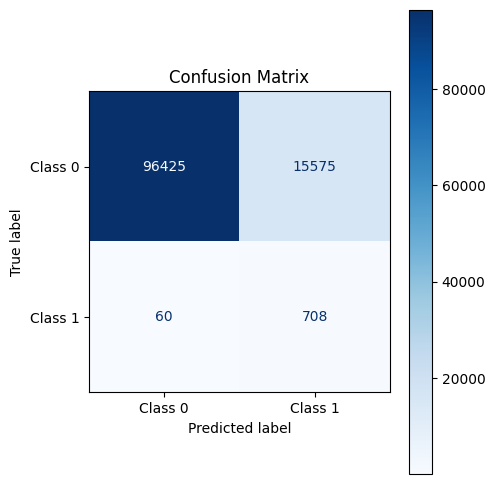


📈 Validation Performance:
Precision: 0.513
Recall:    0.745
F1-score:  0.488

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.86      0.92     24000
           1       0.03      0.63      0.06       164

    accuracy                           0.85     24164
   macro avg       0.51      0.75      0.49     24164
weighted avg       0.99      0.85      0.92     24164



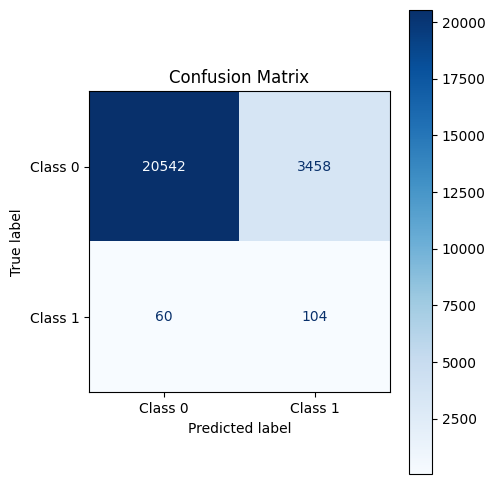

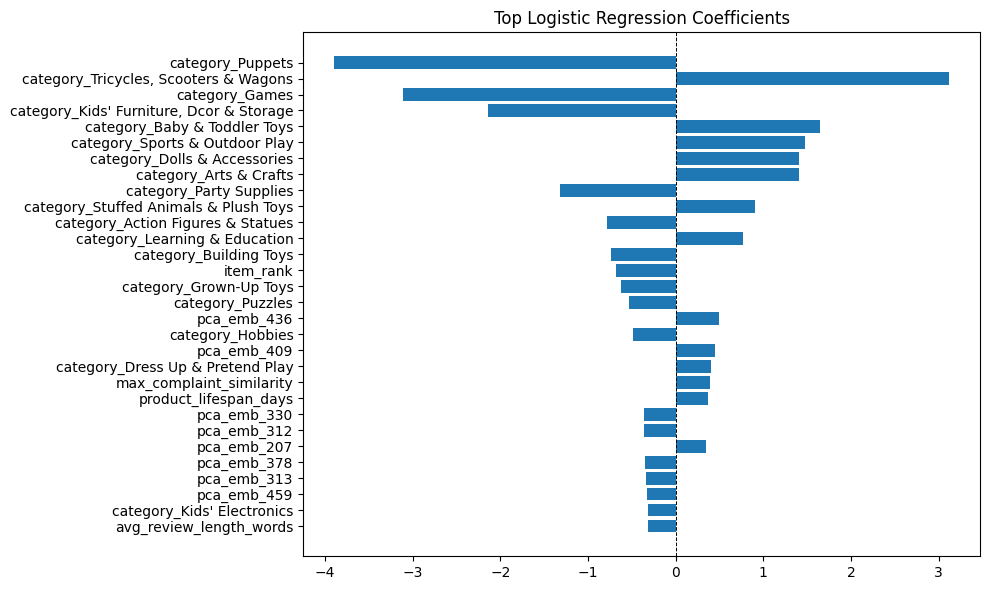

In [155]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

evaluator = ModelEvaluator(
    model=logreg,
    average='macro',   # or 'binary' for binary classification
    display_labels=['Class 0', 'Class 1']  # customize based on your labels
)

logreg = evaluator.fit_and_evaluate(X_train_final_df, y_train, X_val_final_df, y_val)

evaluator.plot_feature_importance(final_feature_names)

## Smote Oversampling

In [50]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_final_df, y_train)

Training model...

📊 Training Performance:
Precision: 0.919
Recall:    0.918
F1-score:  0.918

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92    112000
           1       0.90      0.94      0.92    112000

    accuracy                           0.92    224000
   macro avg       0.92      0.92      0.92    224000
weighted avg       0.92      0.92      0.92    224000



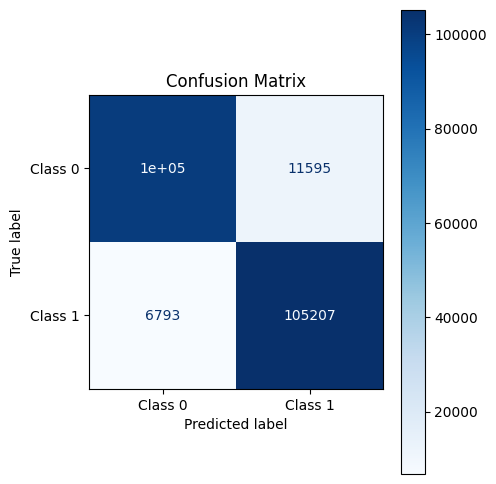


📈 Validation Performance:
Precision: 0.515
Recall:    0.726
F1-score:  0.502

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94     24000
           1       0.03      0.56      0.06       164

    accuracy                           0.89     24164
   macro avg       0.52      0.73      0.50     24164
weighted avg       0.99      0.89      0.93     24164



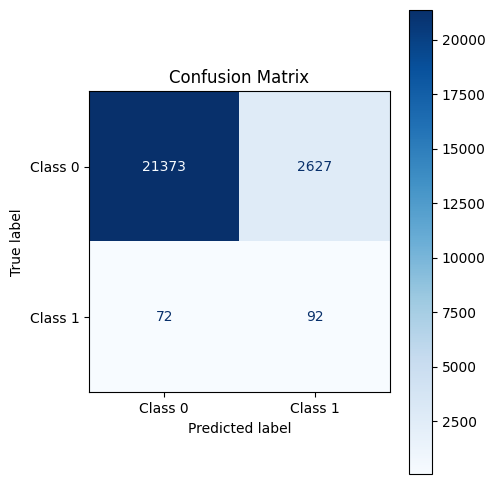

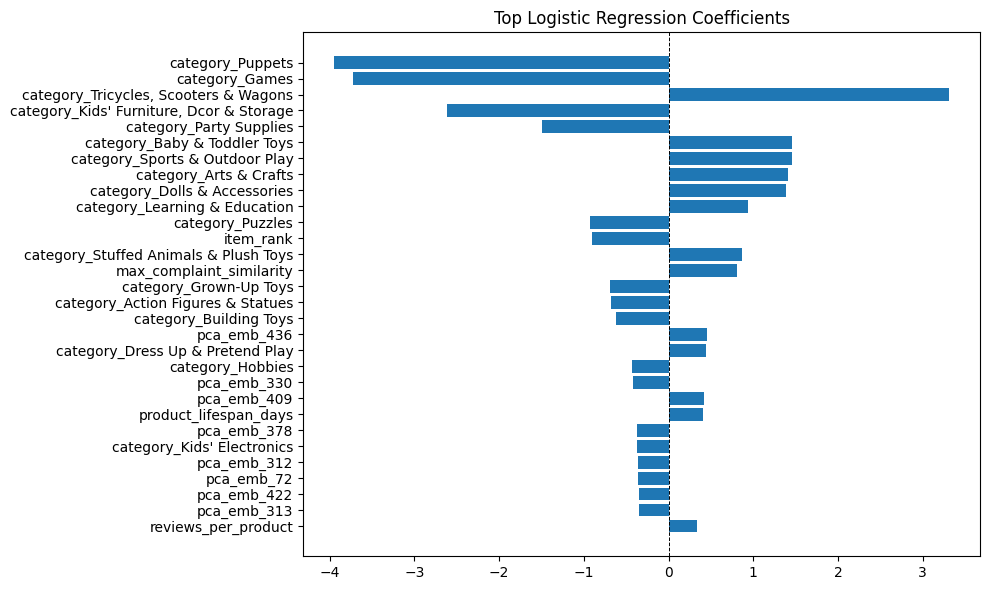

In [164]:
logreg_smote = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

evaluator = ModelEvaluator(
    model=logreg_smote,
    average='macro',   # or 'binary' for binary classification
    display_labels=['Class 0', 'Class 1']  # customize based on your labels
)

logreg_smote = evaluator.fit_and_evaluate(X_train_res, y_train_res, X_val_final_df, y_val)

evaluator.plot_feature_importance(final_feature_names)

## Random Forest Classifier

Training model...

📊 Training Performance:
Precision: 0.083
Recall:    0.854
F1-score:  0.151

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97    112000
           1       0.08      0.85      0.15       768

    accuracy                           0.93    112768
   macro avg       0.54      0.89      0.56    112768
weighted avg       0.99      0.93      0.96    112768



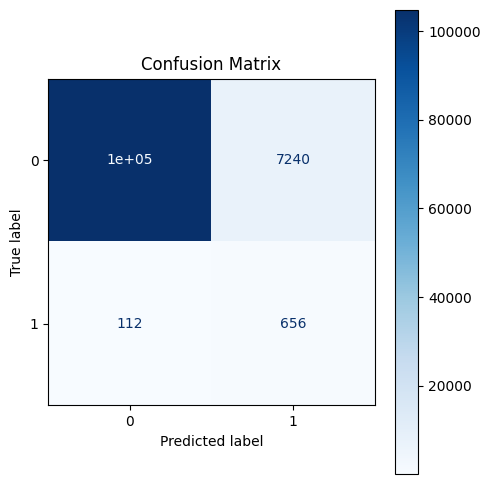


📈 Validation Performance:
Precision: 0.047
Recall:    0.500
F1-score:  0.087

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96     24000
           1       0.05      0.50      0.09       164

    accuracy                           0.93     24164
   macro avg       0.52      0.72      0.52     24164
weighted avg       0.99      0.93      0.96     24164



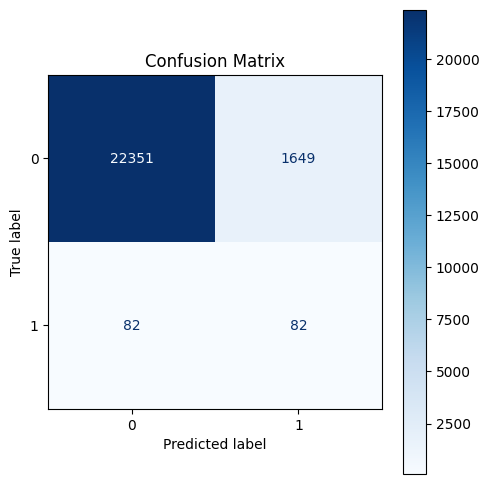

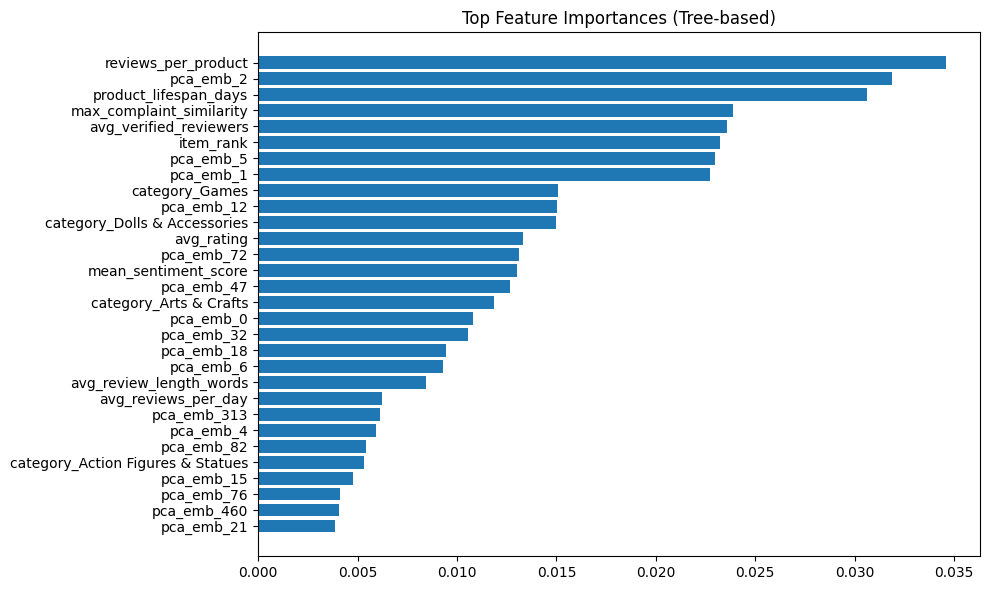

In [168]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=7,                  
    min_samples_split=10,          
    min_samples_leaf=5, 
    max_features='sqrt', 
    class_weight='balanced',      
    random_state=42,
    n_jobs=20
)
evaluator = ModelEvaluator(rf_model, average='binary', display_labels=[0, 1])
evaluator.fit_and_evaluate(X_train_final_df, y_train, X_val_final_df, y_val)

# plot importances
evaluator.plot_feature_importance(final_feature_names)

Training model...

📊 Training Performance:
Precision: 0.067
Recall:    0.850
F1-score:  0.125

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96    112000
           1       0.07      0.85      0.12       768

    accuracy                           0.92    112768
   macro avg       0.53      0.88      0.54    112768
weighted avg       0.99      0.92      0.95    112768



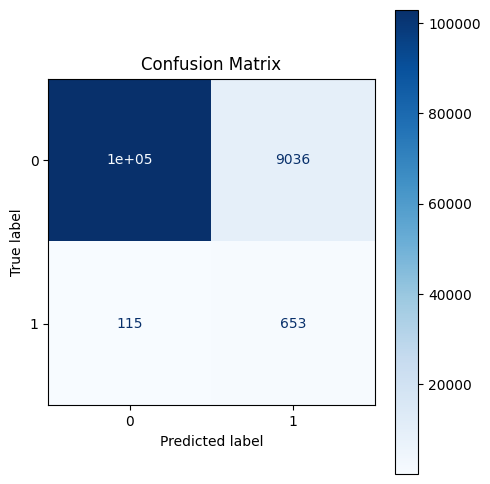


📈 Validation Performance:
Precision: 0.038
Recall:    0.488
F1-score:  0.071

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.95     24000
           1       0.04      0.49      0.07       164

    accuracy                           0.91     24164
   macro avg       0.52      0.70      0.51     24164
weighted avg       0.99      0.91      0.95     24164



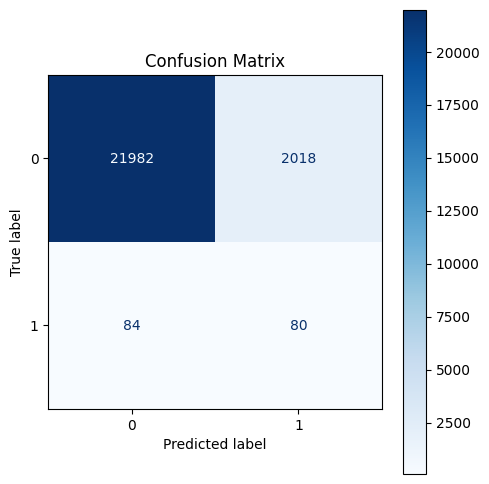

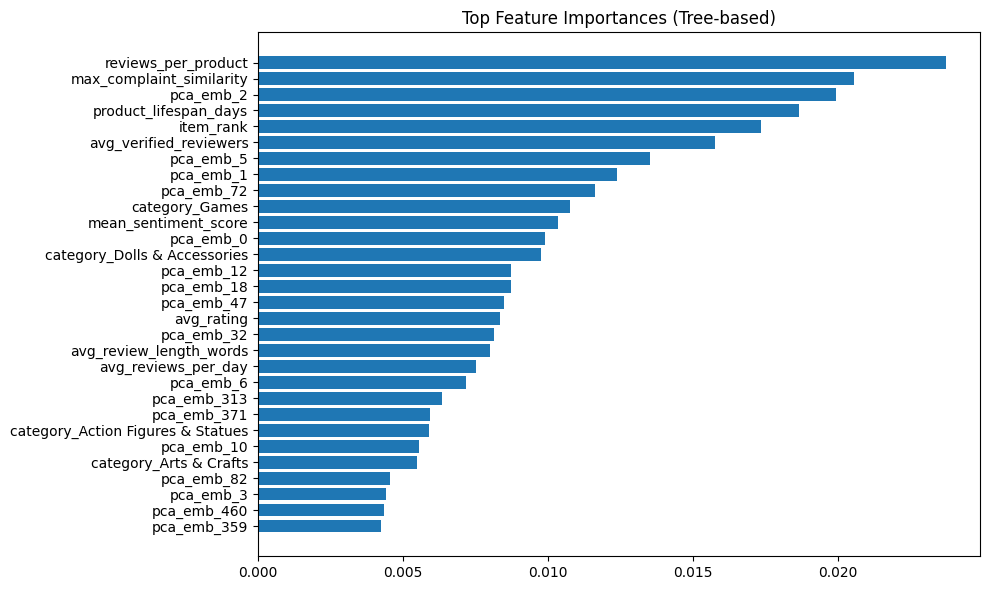

In [170]:
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=7,                  
    min_samples_split=13,          
    min_samples_leaf=5, 
    max_features='log2', 
    class_weight='balanced_subsample',      
    random_state=42,
    n_jobs=20
)
evaluator = ModelEvaluator(rf_model, average='binary', display_labels=[0, 1])
evaluator.fit_and_evaluate(X_train_final_df, y_train, X_val_final_df, y_val)

# plot importances
evaluator.plot_feature_importance(final_feature_names)

### Random forest With Smote

Training model...

📊 Training Performance:
Precision: 0.890
Recall:    0.928
F1-score:  0.909

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.89      0.90    112000
           1       0.89      0.93      0.91    112000

    accuracy                           0.91    224000
   macro avg       0.91      0.91      0.91    224000
weighted avg       0.91      0.91      0.91    224000



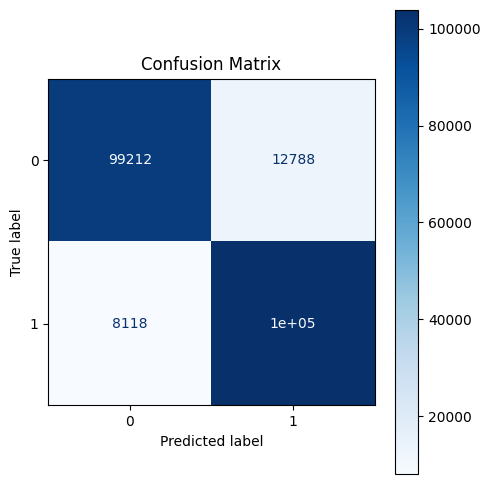


📈 Validation Performance:
Precision: 0.032
Recall:    0.573
F1-score:  0.061

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.88      0.94     24000
           1       0.03      0.57      0.06       164

    accuracy                           0.88     24164
   macro avg       0.51      0.73      0.50     24164
weighted avg       0.99      0.88      0.93     24164



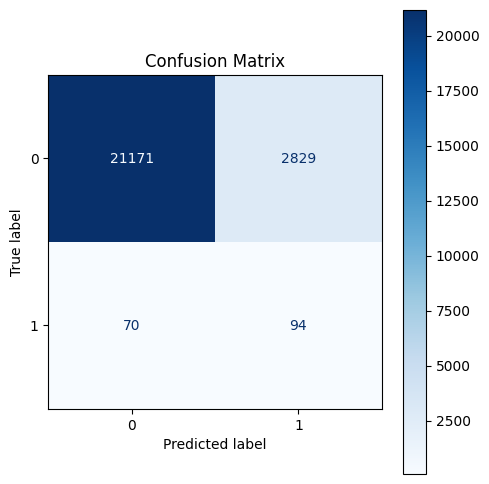

RandomForestClassifier(class_weight='balanced_subsample', max_depth=7,
                       max_features='log2', min_samples_leaf=5,
                       min_samples_split=13, n_estimators=500, n_jobs=20,
                       random_state=42)

In [173]:
rf_model_smote = RandomForestClassifier(
    n_estimators=500,
    max_depth=7,                  
    min_samples_split=13,          
    min_samples_leaf=5, 
    max_features='log2', 
    class_weight='balanced_subsample',      
    random_state=42,
    n_jobs=20
)
evaluator = ModelEvaluator(rf_model_smote, average='binary', display_labels=[0, 1])
evaluator.fit_and_evaluate(X_train_res, y_train_res, X_val_final_df, y_val)

## XGBoost 

Training model...


C:\Users\Betul\anaconda3\envs\pytorch_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:40:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Training Performance:
Precision: 0.146
Recall:    1.000
F1-score:  0.254

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98    112000
           1       0.15      1.00      0.25       768

    accuracy                           0.96    112768
   macro avg       0.57      0.98      0.62    112768
weighted avg       0.99      0.96      0.97    112768



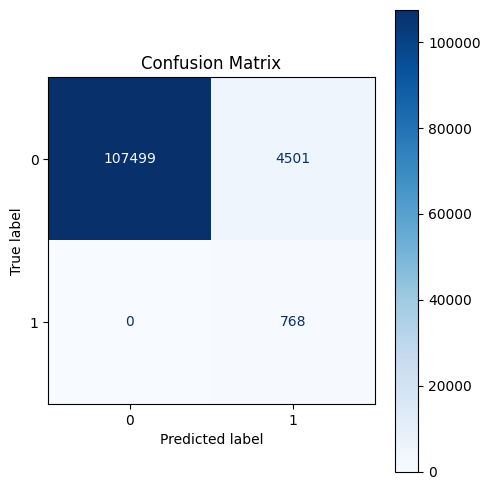


📈 Validation Performance:
Precision: 0.057
Recall:    0.390
F1-score:  0.099

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     24000
           1       0.06      0.39      0.10       164

    accuracy                           0.95     24164
   macro avg       0.53      0.67      0.54     24164
weighted avg       0.99      0.95      0.97     24164



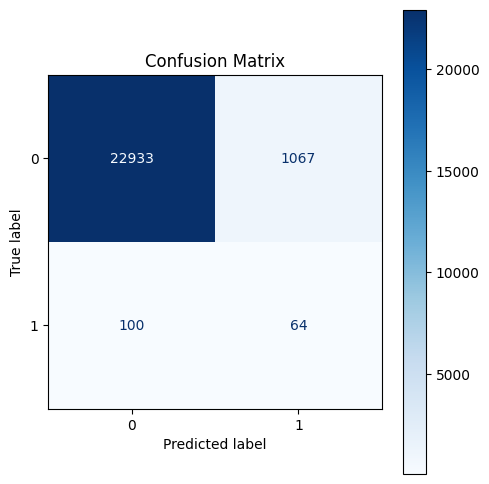

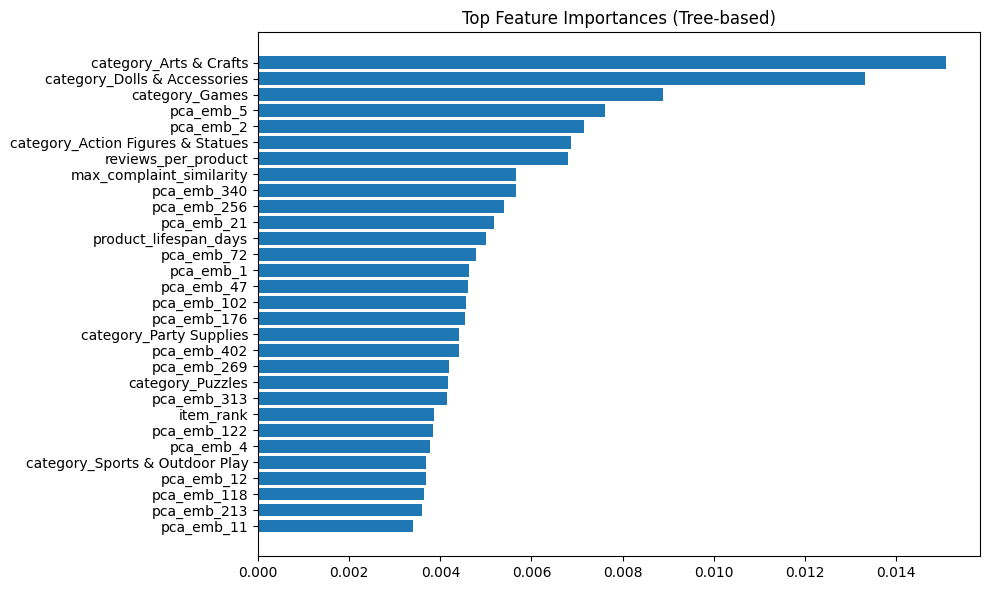

In [184]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,              
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    reg_alpha=0.5,                   # L1
    reg_lambda=1.0,                  # L2
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=20
)


evaluator = ModelEvaluator(xgb_model, average='binary', display_labels=[0, 1])
evaluator.fit_and_evaluate(X_train_final_df, y_train, X_val_final_df, y_val)

# plot importances
evaluator.plot_feature_importance(final_feature_names)

# Several Strategies

## Strategy 1: High-Recall Model Ensemble, Then Calibrate Precision

Testing with weight ratio 1:400
Training model...

📊 Training Performance:
Precision: 0.032
Recall:    0.993
F1-score:  0.063

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89    112000
           1       0.03      0.99      0.06       768

    accuracy                           0.80    112768
   macro avg       0.52      0.89      0.47    112768
weighted avg       0.99      0.80      0.88    112768



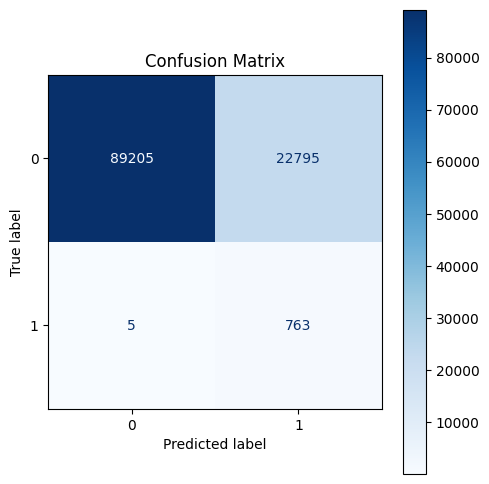


📈 Validation Performance:
Precision: 0.023
Recall:    0.713
F1-score:  0.045

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.88     24000
           1       0.02      0.71      0.05       164

    accuracy                           0.79     24164
   macro avg       0.51      0.75      0.46     24164
weighted avg       0.99      0.79      0.88     24164



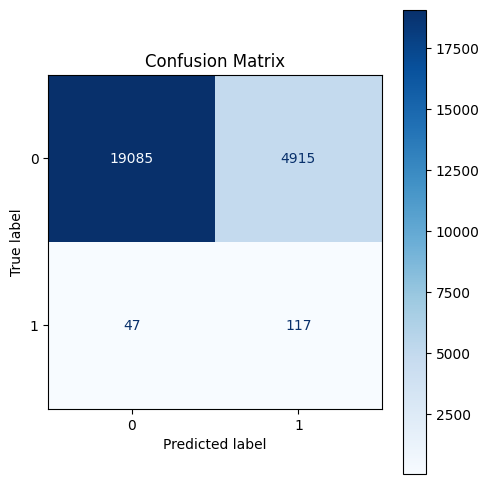

In [41]:
from sklearn.linear_model import LogisticRegression

for w in [400]:
    print(f"Testing with weight ratio 1:{w}")
    logreg = LogisticRegression(max_iter=1000, class_weight={0: 1, 1: w}, random_state=42)
    evaluator = ModelEvaluator(logreg, average='binary', display_labels=[0, 1])
    evaluator.fit_and_evaluate(X_train_final_df, y_train, X_val_final_df, y_val)


Training model...

📊 Training Performance:
Precision: 0.015
Recall:    1.000
F1-score:  0.030

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.56      0.72    112000
           1       0.02      1.00      0.03       768

    accuracy                           0.56    112768
   macro avg       0.51      0.78      0.37    112768
weighted avg       0.99      0.56      0.71    112768



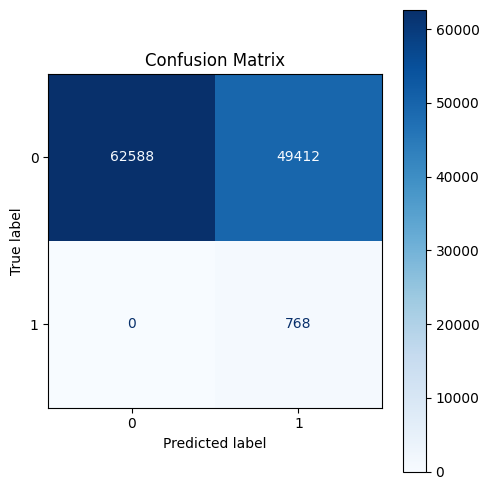


📈 Validation Performance:
Precision: 0.014
Recall:    0.902
F1-score:  0.027

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.55      0.71     24000
           1       0.01      0.90      0.03       164

    accuracy                           0.56     24164
   macro avg       0.51      0.73      0.37     24164
weighted avg       0.99      0.56      0.71     24164



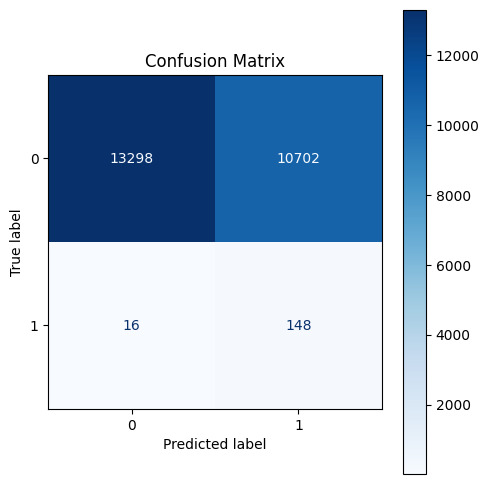

RandomForestClassifier(class_weight={0: 1.0, 1: 600.0}, max_depth=7,
                       min_samples_leaf=5, min_samples_split=10,
                       n_estimators=300, n_jobs=20, random_state=42)

In [46]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=7,                  
    min_samples_split=10,          
    min_samples_leaf=5, 
    max_features='sqrt', 
    class_weight={0: 1.0, 1: 600.0},      
    random_state=42,
    n_jobs=20
)
evaluator = ModelEvaluator(rf_model, average='binary', display_labels=[0, 1])
evaluator.fit_and_evaluate(X_train_final_df, y_train, X_val_final_df, y_val)

Training model...


C:\Users\Betul\anaconda3\envs\pytorch_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:35:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Training Performance:
Precision: 0.861
Recall:    1.000
F1-score:  0.925

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.84      0.91    112000
           1       0.86      1.00      0.93    112000

    accuracy                           0.92    224000
   macro avg       0.93      0.92      0.92    224000
weighted avg       0.93      0.92      0.92    224000



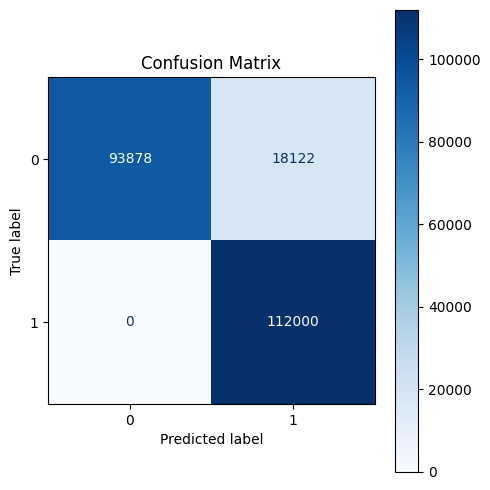


📈 Validation Performance:
Precision: 0.027
Recall:    0.707
F1-score:  0.053

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91     24000
           1       0.03      0.71      0.05       164

    accuracy                           0.83     24164
   macro avg       0.51      0.77      0.48     24164
weighted avg       0.99      0.83      0.90     24164



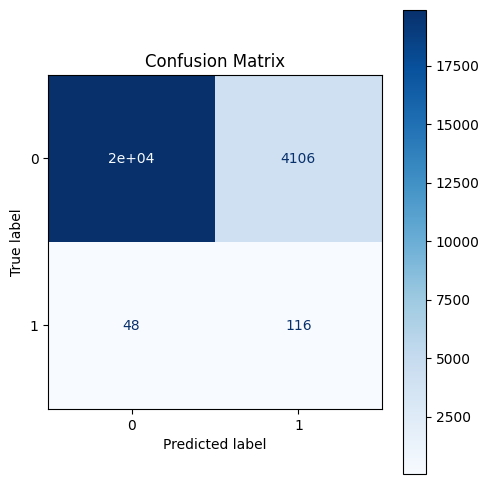

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=20,
              num_parallel_tree=None, ...)

In [52]:
from xgboost import XGBClassifier

xgb_model_smote = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,              
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    reg_alpha=0.5,                   # L1
    reg_lambda=1.0,                  # L2
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=20
)


evaluator = ModelEvaluator(xgb_model_smote, average='binary', display_labels=[0, 1])
evaluator.fit_and_evaluate(X_train_res, y_train_res, X_val_final_df, y_val)



C:\Users\Betul\anaconda3\envs\pytorch_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:45:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "sample_weights", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Precision: 0.041
Recall:    0.585
F1-score:  0.076

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.91      0.95     24000
           1       0.04      0.59      0.08       164

    accuracy                           0.90     24164
   macro avg       0.52      0.75      0.51     24164
weighted avg       0.99      0.90      0.94     24164



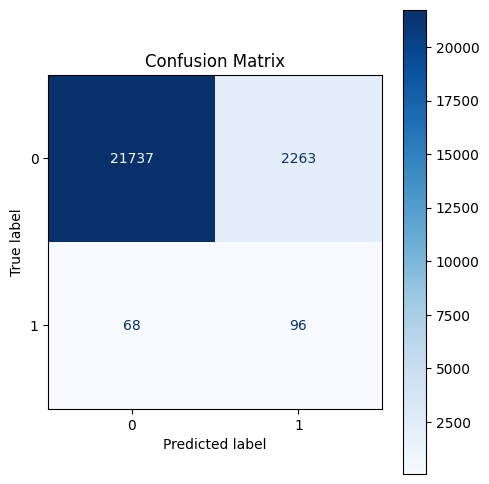

In [61]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ('logreg', logreg),
        ('rf', rf_model),
        ('xgb', xgb_model)
    ],
    voting='soft' 
)

voting_clf.fit(X_train_final_df, y_train) 
evaluator = ModelEvaluator(model=voting_clf, average='binary', display_labels=[0, 1])
evaluator.evaluate_classification(y_val, voting_clf.predict(X_val_final_df))

C:\Users\Betul\anaconda3\envs\pytorch_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:46:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "sample_weights", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Precision: 0.029
Recall:    0.677
F1-score:  0.056

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.85      0.92     24000
           1       0.03      0.68      0.06       164

    accuracy                           0.85     24164
   macro avg       0.51      0.76      0.49     24164
weighted avg       0.99      0.85      0.91     24164



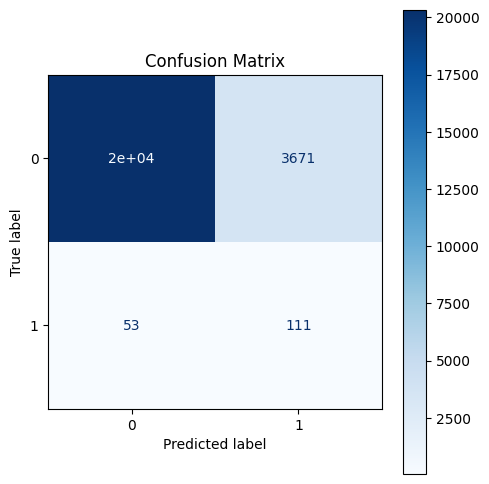

In [63]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ('logreg', logreg),
        ('rf', rf_model),
        ('xgb', xgb_model)
    ],
    voting='hard' 
)

voting_clf.fit(X_train_final_df, y_train) 
evaluator = ModelEvaluator(model=voting_clf, average='binary', display_labels=[0, 1])
evaluator.evaluate_classification(y_val, voting_clf.predict(X_val_final_df))

## SGDClassifier

Training model...

📊 Training Performance:
Precision: 0.000
Recall:    0.000
F1-score:  0.000

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    112000
           1       0.00      0.00      0.00       768

    accuracy                           0.99    112768
   macro avg       0.50      0.50      0.50    112768
weighted avg       0.99      0.99      0.99    112768



C:\Users\Betul\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Betul\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Betul\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result

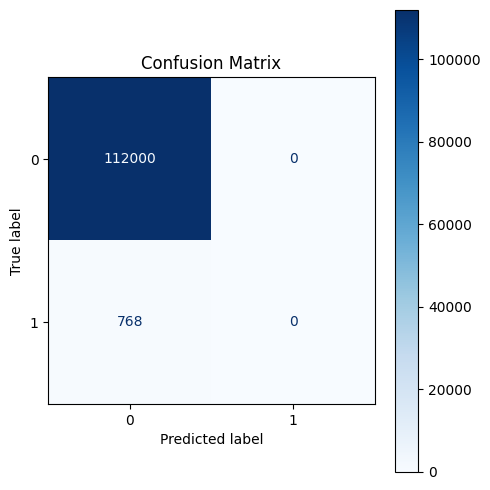


📈 Validation Performance:
Precision: 0.000
Recall:    0.000
F1-score:  0.000

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     24000
           1       0.00      0.00      0.00       164

    accuracy                           0.99     24164
   macro avg       0.50      0.50      0.50     24164
weighted avg       0.99      0.99      0.99     24164



C:\Users\Betul\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Betul\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Betul\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result

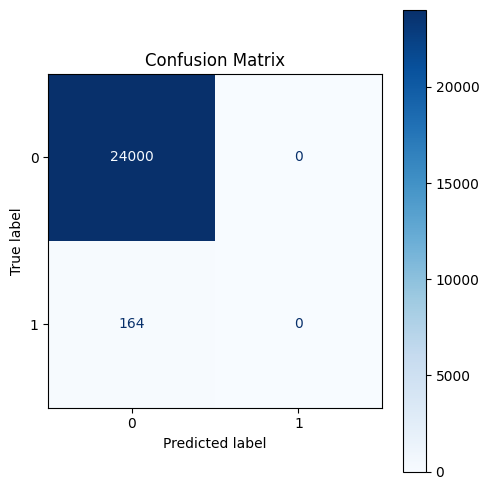

In [15]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

sgd_model = SGDClassifier(
    loss='hinge',                # SVM loss
    class_weight='balanced',
    penalty='l2',
    alpha=1e-4,
    random_state=42,
    max_iter=1000,
    tol=1e-3
)

# Optional: Calibrate to get probabilities
calibrated_sgd = CalibratedClassifierCV(sgd_model, cv=3, method='sigmoid')

# Use your evaluator
evaluator = ModelEvaluator(calibrated_sgd, average='binary', display_labels=[0, 1])
calibrated_sgd = evaluator.fit_and_evaluate(X_train_final_df, y_train, X_val_final_df, y_val)
